In [1]:
import pyvista as pv
pv.set_jupyter_backend('static')


# STL laden
mesh = pv.read("./wärmeübertrager/meshing/constant/triSurface/domain_a3_b1.stl")

# 3D-Plot
pl = pv.Plotter()
pl.add_mesh(mesh, show_edges=True, color="lightgray")
pl.add_axes()  # Koordinatenachsen anzeigen

# Kameraposition einstellen
pl.camera_position = 'xy'
cam, foc, up = pl.camera_position
dx = -0.2
pl.camera_position = [(cam[0]+dx, cam[1], cam[2]), (foc[0]+dx, foc[1], foc[2]), (up[0], up[1], up[2])]  # Kameraposition einstellen
pl.camera.zoom(4)

# Domain
x_min, x_max = -0.1, 0.08
y_min, y_max = -0.0225, 0.0225
z = 0.01
pointa = [x_min, y_min, z]
pointb = [x_min, y_max, z]
pointc = [x_max, y_min, z]
domain = pv.Rectangle([pointa, pointb, pointc])
pl.add_mesh(domain, color="green", show_edges=True, line_width=5, render_lines_as_tubes=False, opacity=0.2)

# Inlet
dy = 0.01
dx = -0.01
inlet = pv.Line((x_min, y_min -  dy, z), (x_min, y_max + dy, z))
pl.add_mesh(inlet, color="black", line_width=5)
label_inlet = pv.Label("Inlet", position=(x_min + dx, y_max + 0.015, z), size=40)
pl.add_actor(label_inlet)
label_inlet_x = pv.Label(f"x = {x_min}", position=(x_min + dx, y_min - 0.02, z), size=30)
pl.add_actor(label_inlet_x)

# Outlet
outlet = pv.Line((x_max, y_min -  dy, z), (x_max, y_max + dy, z))
pl.add_mesh(outlet, color="black", line_width=5)
label_outlet = pv.Label("Outlet", position=(x_max + dx, y_max + 0.015, z), size=40)
pl.add_actor(label_outlet)
label_outlet_x = pv.Label(f"x = {x_max}", position=(x_max + dx, y_min - 0.02, z), size=30)
pl.add_actor(label_outlet_x)

# Top und Bottom
top_label_y = pv.Label(f"y_max = {y_max}", position=((x_min + x_max)/2 + dx, y_max + 0.015, z), size=30)
bottom_label_y = pv.Label(f"y_min = {y_min}", position=((x_min + x_max)/2 + dx, y_min - 0.02, z), size=30)
pl.add_actor(top_label_y)
pl.add_actor(bottom_label_y)

# Gitter und Achsenbeschriftung anzeigen
pl.save_graphic("img/aufgabe2_skizze.svg")


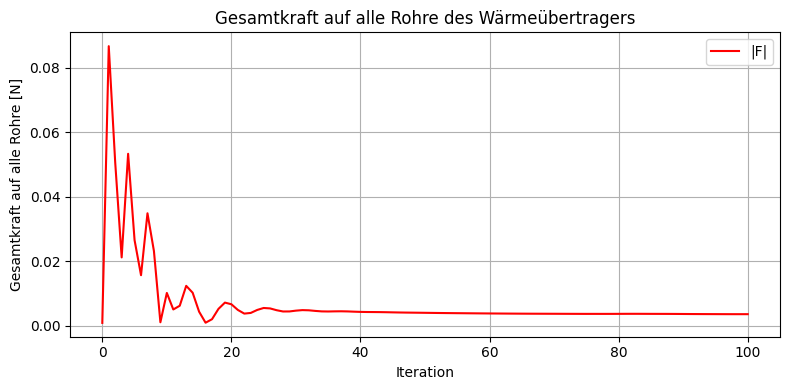

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

file = "wärmeübertrager/postProcessing/forcesPipe/0/forces.dat"

times = []
Fx = []
Fy = []
Fz = []

pattern = re.compile(r"\(\((.*?)\)\s+\((.*?)\)\)")  # matches: ((pressure) (viscous))

with open(file) as f:
    for line in f:
        if line.startswith("#"):
            continue

        parts = line.split()
        t = float(parts[0])          # time

        # Extract the two force vectors via regex
        matches = pattern.findall(line)
        if not matches:
            continue

        # First match → forces block: (pressureVec) (viscousVec)
        pressure_str, viscous_str = matches[0]

        px, py, pz = map(float, pressure_str.split())
        vx, vy, vz = map(float, viscous_str.split())

        Fx.append(px + vx)
        Fy.append(py + vy)
        Fz.append(pz + vz)
        times.append(t)

F = np.sqrt(np.array(Fx)**2 + np.array(Fy)**2 + np.array(Fz)**2)
# Plot
plt.figure(figsize=(8,4))
plt.plot(times, F, label="|F|", linestyle='-', color='r')
plt.title("Gesamtkraft auf alle Rohre des Wärmeübertragers")
plt.xlabel("Iteration")
plt.ylabel("Gesamtkraft auf alle Rohre [N]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("img/aufgabe3_maxForce.png", dpi=160)




FileNotFoundError: [Errno 2] No such file or directory: 'wärmeübertrager/postProcessing/forcePipe0/0/forces.dat'

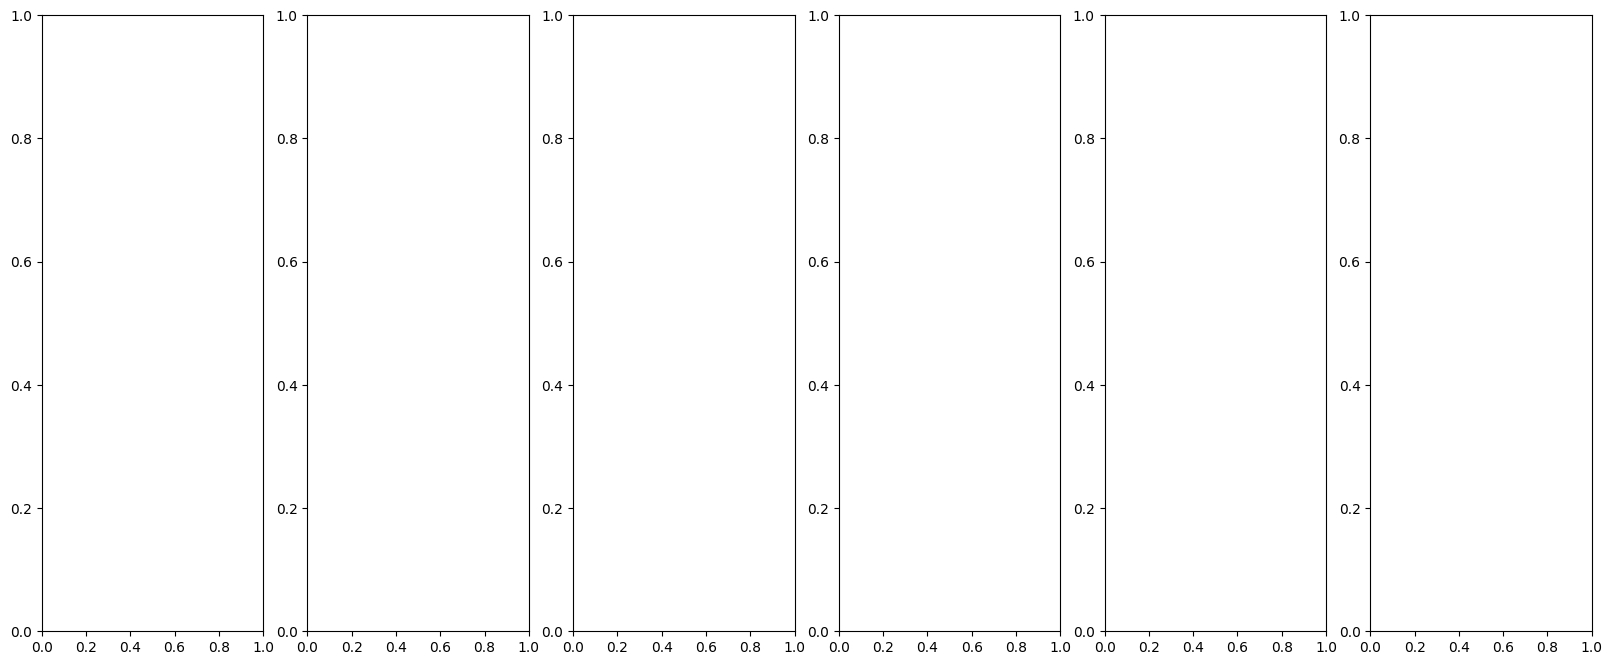

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re

files = [f"wärmeübertrager/postProcessing/forcePipe{index}/0/forces.dat" for index in range(0, 6)]

forces = {}

pattern = re.compile(r"\(\((.*?)\)\s+\((.*?)\)\)")  # matches: ((pressure) (viscous))

fig, axes = plt.subplots(1, 6, figsize=(20,8), sharex=True)
axes = axes.flatten()

for count, file in enumerate(files):
    times = []
    Fx = []
    Fy = []
    Fz = []

    with open(file) as f:
        for line in f:
            if line.startswith("#"):
                continue

            parts = line.split()
            t = float(parts[0])          # time

            # Extract the two force vectors via regex
            matches = pattern.findall(line)
            if not matches:
                continue

            # First match → forces block: (pressureVec) (viscousVec)
            pressure_str, viscous_str = matches[0]

            px, py, pz = map(float, pressure_str.split())
            vx, vy, vz = map(float, viscous_str.split())

            Fx.append(px + vx)
            Fy.append(py + vy)
            Fz.append(pz + vz)
            times.append(t)

    F = np.sqrt(np.array(Fx)**2 + np.array(Fy)**2 + np.array(Fz)**2)
    forces[count] = (f"Röhre {count}", F.max())

    # Plot
    axes[count].plot(times[:20], F[:20], label="|F|")
    axes[count].set_title(f"Röhre {count}")
    axes[count].grid(True)
    axes[count].set_ylabel("Gesamtkraft [N]")
    axes[count].set_xlabel("TIteration")
    axes[count].set_xlim([0, times[19]])
    axes[count].set_ylim([0, 0.016])
    axes[count].axhline(F.max(), color='red', linestyle='-')
    axes[count].legend()

print("Maximale Kräfte auf die Rohre:")
for key, value in forces.items():
    print(f"{value[0]}: {value[1]:.6f} N")

print(f"Maximale Kraft wird auf Röhre {max(forces, key=lambda x: forces[x][1])}: {max(forces.values(), key=lambda x: x[1])[1]:.6f} N ausgeübt.")

plt.tight_layout()
plt.savefig("img/aufgabe4_maxForce_pipe.png", dpi=160)



In [10]:
import pandas as pd

def get_inlet_velocity(case, print_result=True):
    with open(f"{case}/0/U") as f:
        for line in f:
            if line.strip().startswith("meanVelo"):
                if print_result:
                    print(f"Einlassgeschwindigkeit im Fall {case}: {float(line.split()[1].strip(';'))} m/s")
                return(float(line.split()[1].strip(";")))

def get_pressure_drop(case, print_result=True):
    data = np.loadtxt(f"{case}/postProcessing/avgPres/0/surfaceFieldValue.dat")
    p_in = data[-1,1]      # letzte Iteration inlet
    p_out = 0
    if print_result:
        print(f"Druckabfall im Fall {case}: Δp = {float(p_in) - p_out} Pa")
    return (float(p_in) - p_out)

def get_velocity_stats(case, print_result=True):
    # maximum velocity in the domain
    cell_max = pd.read_csv(f"{case}/postProcessing/cellMax/0/volFieldValue.dat", sep=r'\s+', comment='#')
    cell_max.columns = ["iteration", "ux", "uy", "uz"]
    cell_max["ux"] = cell_max["ux"].str.replace("(", "", regex=False)
    cell_max["uy"] = cell_max["uy"]
    cell_max["uz"] = cell_max["uz"].str.replace(")", "", regex=False)
    ux_max = cell_max["ux"].astype(float).iloc[-1]
    uy_max = cell_max["uy"].astype(float).iloc[-1]
    uz_max = cell_max["uz"].astype(float).iloc[-1]
    U_max = np.sqrt(ux_max**2 + uy_max**2 + uz_max**2)
    if print_result:
        print(f"Maximale Geschwindigkeiten im Fall {case}: ux_max = {ux_max:.4f} m/s, uy_max = {uy_max:.4f} m/s, uz_max = {uz_max:.4f} m/s, U_max = {U_max:.4f} m/s")

    # average velocity in the domain
    cell_avg = pd.read_csv(f"{case}/postProcessing/volAverage/0/volFieldValue.dat", sep=r'\s+', comment='#')
    cell_avg.columns = ["iteration", "ux", "uy", "uz"]
    cell_avg["ux"] = cell_avg["ux"].str.replace("(", "", regex=False)
    cell_avg["uy"] = cell_avg["uy"]
    cell_avg["uz"] = cell_avg["uz"].str.replace(")", "", regex=False)
    ux_avg = cell_avg["ux"].astype(float).iloc[-1]
    uy_avg = cell_avg["uy"].astype(float).iloc[-1]
    uz_avg = cell_avg["uz"].astype(float).iloc[-1]
    U_avg = np.sqrt(ux_avg**2 + uy_avg**2 + uz_avg**2)
    if print_result:
        print(f"Mittlere Geschwindigkeiten im Fall {case}: ux_avg = {ux_avg:.4f} m/s, uy_avg = {uy_avg:.4f} m/s, uz_avg = {uz_avg:.4f} m/s, U_avg = {U_avg:.4f} m/s")

def get_force_on_pipes(case, print_result=True):
    pattern = re.compile(r"\(\((.*?)\)\s+\((.*?)\)\)")  # matches: ((pressure) (viscous))
    file = f"{case}/postProcessing/forcesPipe/0/forces.dat"
    times = []
    Fx = []
    Fy = []
    Fz = []
    with open(file) as f:
        for line in f:
            if line.startswith("#"):
                continue

            parts = line.split()
            t = float(parts[0])          # time

            # Extract the two force vectors via regex
            matches = pattern.findall(line)
            if not matches:
                continue

            # First match → forces block: (pressureVec) (viscousVec)
            pressure_str, viscous_str = matches[0]

            px, py, pz = map(float, pressure_str.split())
            vx, vy, vz = map(float, viscous_str.split())

            Fx.append(px + vx)
            Fy.append(py + vy)
            Fz.append(pz + vz)
            times.append(t)

    Fx_mean = np.mean(np.array(Fx))
    Fy_mean = np.mean(np.array(Fy))
    Fz_mean = np.mean(np.array(Fz))
    if print_result:
        print(f"Mittlere Kräfte auf die Rohre im Fall {case}: Fx_mean = {Fx_mean:.6f} N, Fy_mean = {Fy_mean:.6f} N, Fz_mean = {Fz_mean:.6f} N")


def get_max_and_min_pressure_on_pipes(case, print_result=True):
    rows = []

    for i in range(6):
        min_file = f"{case}/postProcessing/minPres_pipe{i}/0/surfaceFieldValue.dat"
        max_file = f"{case}/postProcessing/maxPres_pipe{i}/0/surfaceFieldValue.dat"

        df_min = pd.read_csv(min_file, sep=r"\s+", comment="#", names=["time", "value"])
        df_max = pd.read_csv(max_file, sep=r"\s+", comment="#", names=["time", "value"])

        rows.append({
            "pipe": f"pipe-{i}",
            "min_p": df_min["value"].iloc[-1],
            "max_p": df_max["value"].iloc[-1]
        })

    df = pd.DataFrame(rows)
    if print_result:
        print(df)

    return df

def get_max_and_mean_yplus(case, print_result=True):
    yplus_data = pd.read_csv(f"{case}/postProcessing/yPlus/0/yPlus.dat", sep=r'\s+', comment='#')
    yplus_data.columns = ["time", "Patch", "Min", "Max", "Mean"]
    max_yplus = yplus_data["Max"].iloc[-1]
    mean_yplus = yplus_data["Mean"].iloc[-1]
    if print_result:
        print(f"Maximaler yPlus im Fall {case}: {max_yplus:.4f}")
        print(f"Mittlerer yPlus im Fall {case}: {mean_yplus:.4f}")

def get_num_layers(case, print_result=True):
    pattern = re.compile(r"nSurfaceLayers\s+(\d+)")
    with open(f"{case}/meshing/system/snappyHexMeshDict") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                if print_result:
                    print(f"Anzahl der Schichten im Fall {case}: {match.group(1)}")
                return int(match.group(1))


In [11]:
get_inlet_velocity("wärmeübertrager")
get_pressure_drop("wärmeübertrager")
get_velocity_stats("wärmeübertrager")
get_force_on_pipes("wärmeübertrager")
get_max_and_min_pressure_on_pipes("wärmeübertrager")
get_max_and_mean_yplus("wärmeübertrager")
get_num_layers("wärmeübertrager")


Einlassgeschwindigkeit im Fall wärmeübertrager: 1.0 m/s
Druckabfall im Fall wärmeübertrager: Δp = 3.336692 Pa
Maximale Geschwindigkeiten im Fall wärmeübertrager: ux_max = 2.7406 m/s, uy_max = 1.3338 m/s, uz_max = 0.0000 m/s, U_max = 3.0480 m/s
Mittlere Geschwindigkeiten im Fall wärmeübertrager: ux_avg = 1.0368 m/s, uy_avg = -0.0008 m/s, uz_avg = -0.0000 m/s, U_avg = 1.0368 m/s
Mittlere Kräfte auf die Rohre im Fall wärmeübertrager: Fx_mean = 0.004613 N, Fy_mean = 0.000001 N, Fz_mean = 0.000000 N
     pipe     min_p     max_p
0  pipe-0  1.141113  3.937229
1  pipe-1 -0.813020  4.049789
2  pipe-2 -1.776151  2.351467
3  pipe-3 -2.195031  1.385810
4  pipe-4 -2.814645  0.869979
5  pipe-5 -1.992557  0.389396
Maximaler yPlus im Fall wärmeübertrager: 4.2765
Mittlerer yPlus im Fall wärmeübertrager: 2.2715
Anzahl der Schichten im Fall wärmeübertrager: 2


2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

table = pd.DataFrame({
    "Anströmgeschwindigkeit [m/s]": [],
    "Druckverlust zwischen Ein- und Auslass [Pa]": []
    "Maximale und mittlere Geschwindigkeit der Strömung [m/s]": []
    "Gesamtkraft auf Rohe in x-Richtung / Breite des Gebiets in z-Richtung": []
    "Maximaler und minimaler Druck an Rohrwänden [Pa]": []
    "maximales und mittleres y+": []
    "Anzahl der Wandschichten": []
})